# Bifurcation diagrams

Code to calclulate and plot bifurcation diagrams presented in Figure 9 of 
Shevtosva NA, Lockhart AB, Rybak IA, Magnuson DSK, Danner SM. **Reorganization of spinal neural connectivity following recovery after thoracic spinal cord injury: insights from computational modelling.** *bioRxiv*, 2025.xxxx; doi: [xxxx](https://doi.org/xxxx)


Copyright (c) 2023 The Authors. Licensed under [GNU GPL v3](https://www.gnu.org/licenses/gpl-3.0).

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:  # noqa: E722
    IN_COLAB = False

if IN_COLAB:
    !mkdir ./installs
    %cd ./installs
    !git clone https://github.com/SimonDanner/CPGNetworkSimulator
    %cd ./CPGNetworkSimulator
    !pip install pybind11 scoop
    !pip install .
    %cd ../..
    !git clone https://github.com/dannerlab/rat-sci-locomotion-model
    %cd rat-sci-locomotion-model

In [9]:
import CPGNetworkSimulator.tools.py_simulator as nsim
import matplotlib.pyplot as plt
import numpy as np
from yaml_sim import update_sim_from_yaml,yamlload
import os
from classify_gait import classify_gait
import seaborn as sns
import pandas as pd


class suppress_stdout_stderr(object):
    def __enter__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for _ in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors
        self.save_fds = [os.dup(1), os.dup(2)]
        # Assign the null pointers to stdout and stderr
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close all file descriptors
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

def plot_1d_bifurcation_diagram_seg(v,fq,ph,fl_dur,ex_dur,fig_size=(8,10),fqmax=8.0,do_symmetry=True):
    
    cp=sns.color_palette("Paired", 20)
    cp[0]=cp[11]
    cp.pop(7)
    cols = []
    gaits = []
    for i in range(ph.shape[2]):
        df = pd.DataFrame([])
        df['v']=v
        df['LR_h']=  ph[:,0,i]
        df['LR_f']=  ph[:,1,i]
        df['hl']=    ph[:,2,i]
        df['diag']=  ph[:,3,i]
        df['hl_r']=  ph[:,4,i]
        df['diag_2']=ph[:,5,i]
        df['duty_factor']=ex_dur[:,0]/(fl_dur[:,0]+ex_dur[:,i])

        df['duty_factor']=ex_dur[:,0]/(fl_dur[:,0]+ex_dur[:,i])
        classify_gait(df)
        
        col = [cp[k] for k in df.gaits2.cat.codes.values]
        cols.append(col)
        gaits.append(df.gaits2)
    
    ind_ = [[0,-1],[1,-1],[2,4],[4,2],[3,5],[5,3]]
    thr = 45*np.pi/180
    xl= [0.,v[-1]+v[1]-v[0]]
    fig,axs=plt.subplots(9, 1, sharex='all')
    fig.set_size_inches(fig_size)
    for i,c in enumerate(['b','r']):
        ph_ = ph[:,:,i]*2*np.pi
        diffs_=np.sqrt(np.sum(np.angle(np.exp(1j * ph_[1:]) / np.exp(1j * ph_[:-1])) ** 2, axis=1))
        i_sep = np.where(diffs_ > thr)[0]
        i_sep = np.concatenate(([0], i_sep+1, [len(ph_)]))
        segments = []
        for i in range(len(i_sep)-1):
            segments.append((v[i_sep[i]:i_sep[i+1]], ph_[i_sep[i]:i_sep[i+1]]))
        for v_seg,ph_seg in segments:
            for j in range(ph.shape[1]):
                for jj in ind_[j]:
                    if jj==-1:
                        pd_ = -1*ph_seg[:,ind_[j][0]]+np.pi*2
                    else:
                        pd_ = ph_seg[:,jj]
                    
                    pdu = np.unwrap(pd_)
                    if np.nanmax(pdu) < 2*np.pi+0.05:
                        pd_ = pdu
                    i_sep2 = np.where(np.abs(np.diff(pd_)) > np.pi / 2)[0]
                    
                    i_sep2 = np.concatenate(([0], i_sep2+1, [len(pd_)]))
                    for k in range(len(i_sep2)-1):
                        axs[j].plot(v_seg[i_sep2[k]:i_sep2[k+1]],pd_[i_sep2[k]:i_sep2[k+1]]/(np.pi*2), c)
                    if not do_symmetry:
                        break
                
        for j in range(ph.shape[1]):
            
            axs[j].plot(xl,[0.5,0.5],'k--',lw=0.5)
            axs[j].plot(xl,[0.0,0.0],'k--',lw=0.5)
            axs[j].plot(xl,[1.0,1.0],'k--',lw=0.5)
            axs[j].set_xlim(xl)
            axs[j].set_ylim([-0.05, 1.05])
    
    axs[len(ind_)].plot(v,fq[:,0],'b',linewidth=1,)
    axs[len(ind_)].plot(v,fq[:,1],'r',linewidth=1)
    axs[len(ind_)].set_ylim([0.0, fqmax])
    for i in range(2):
        axs[len(ind_) + i + 1].scatter(v, gaits[i].cat.codes.values, c=[cp[k] for k in gaits[i].cat.codes.values],s=2)
    
    sns.despine()
    axs[0].set_ylabel('hLR pd.')
    axs[1].set_ylabel('fLR pd.')
    axs[2].set_ylabel('hl_l pd.')
    axs[3].set_ylabel('hl_r pd.')
    axs[4].set_ylabel('diag pd.')
    axs[5].set_ylabel('diag2 pd.')
    axs[6].set_ylabel('fq')
    axs[7].set_ylabel('gaits up')
    axs[8].set_ylabel('gaits down')
    axs[8].set_xlabel('alpha')
    return fig,axs
    

In [10]:
def run_1d_bifurcation(config_fn,a_range = [0.1, 1.1],steps_per_alpha=1000,its_limit=10):
    config = yamlload(config_fn)
    neurons = ["RGF_NaP_hind_L", "RGF_NaP_hind_R",      # neurons to be read every time step 
                "RGF_NaP_fore_L", "RGF_NaP_fore_R"]
    
    steps = int((a_range[1]-a_range[0])*steps_per_alpha+1)
    
    modelname = config['model_file_name']
    filename = "./models/" + modelname
    case_ = config['case']
    do_symmetry = True
    case_ = 'intact'
    if 'hemi' in config['case']:
        case_ = 'hemisection'
        do_symmetry = False
    if 'cont' in config['case']:
        case_ = 'contusion'
    
    cpg_sim = nsim.simulator(neurons=neurons, filename=filename,dt=0.001,duration=25.) # instantiate simulator
    with suppress_stdout_stderr():
        cpg_sim.initialize_simulator()
        update_sim_from_yaml(config,cpg_sim)
    cpg_sim.its_limit = its_limit
    
    v, fq, ph,fl_dur,ex_dur, _ = cpg_sim.do_1d_bifurcation('alpha', a_range, steps)
    fig,axs = plot_1d_bifurcation_diagram_seg(v, fq, ph, fl_dur,ex_dur,do_symmetry=do_symmetry)
    axs[0].set_xlim([0.0,1.1])
    
    

## Bifurcation diagram of the intact case (Figure 9A1)


updating variables


max iterations reached - max std phases: 0.163 > limit 0.005 - variable: alpha    0.100
max iterations reached - max std phases: 0.050 > limit 0.005 - variable: alpha    0.101
max iterations reached - max std phases: 0.200 > limit 0.005 - variable: alpha    0.102
max iterations reached - max std phases: 0.191 > limit 0.005 - variable: alpha    0.103
max iterations reached - max std phases: 0.058 > limit 0.005 - variable: alpha    0.104
max iterations reached - max std phases: 0.163 > limit 0.005 - variable: alpha    0.105
max iterations reached - max std phases: 0.045 > limit 0.005 - variable: alpha    0.106
max iterations reached - max std phases: 0.017 > limit 0.005 - variable: alpha    0.107
max iterations reached - max std phases: 0.080 > limit 0.005 - variable: alpha    0.108
max iterations reached - max std phases: 0.072 > limit 0.005 - variable: alpha    0.109
Iter 10 of 1001*2; It/sec 0.228
Iter 20 of 1001*2; It/sec 1.916
Iter 30 of 1001*2; It/sec 2.511
It

/var/folders/fz/27jjxdfx3jz5zh_vzsrj6dcm0000gp/T/ipykernel_73571/3549386355.py:76: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(pdu) < 2*np.pi+0.05:


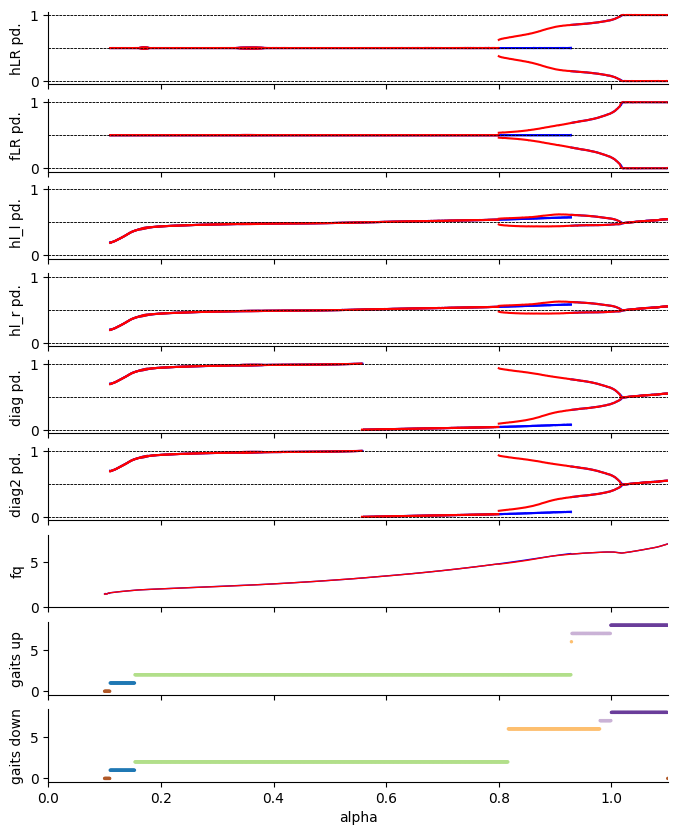

In [3]:
run_1d_bifurcation('./models/config_intact_final.yaml')

## Bifurcation diagram: hemisection (Figure 9A2)


updating variables
group update - name: LPN_hemi_vars , group: LPN_hemi_vars , factor: 0.4
variable name         from     -> to      
aV3diagtoRGF_L       0.6500000 -> 0.2600000
dV0DdiagtoRGF_L      0.7500000 -> 0.3000000
dV0VdiagtoRGF_L      0.2000000 -> 0.0800000
aSh2toRGF_R          0.4000000 -> 0.1600000
dSh2toRGF_R          0.0500000 -> 0.0200000
dLPNitoRGF_R         0.1000000 -> 0.0400000


group update - name: LPN_intact_vars , group: LPN_intact_vars , factor: 1
variable name         from     -> to      
aV3diagtoRGF_R       0.6500000 -> 0.6500000
dV0DdiagtoRGF_R      0.7500000 -> 0.7500000
dV0VdiagtoRGF_R      0.2000000 -> 0.2000000
aSh2toRGF_L          0.4000000 -> 0.4000000
dSh2toRGF_L          0.0500000 -> 0.0500000
dLPNitoRGF_L         0.1000000 -> 0.1000000


group update - name: ipsilesional_hind_RGF_drive , group: RGF_drive_vars , postfix: ['_h_R'] , factor: 0.9
variable name         from     -> to      
drive_to_RGF_h_R     0.0000100 -> 0.0000090


group update - name:

/var/folders/fz/27jjxdfx3jz5zh_vzsrj6dcm0000gp/T/ipykernel_73571/2984254066.py:76: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(pdu) < 2*np.pi+0.05:


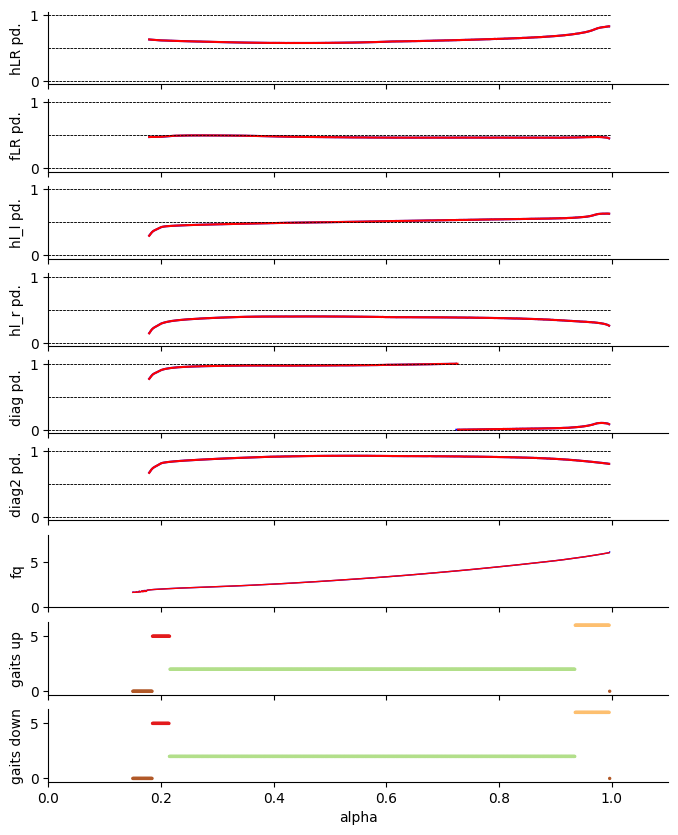

In [12]:
run_1d_bifurcation('./models/config_hemi_final.yaml',a_range=[0.15,0.996])

## Bifurcation diagram: only affected LPNs (Figure 9A3)
all other parameters were left at their pre-injury values


updating variables
group update - name: LPN_hemi_vars , group: LPN_hemi_vars , factor: 0.4
variable name         from     -> to      
aV3diagtoRGF_L       0.6500000 -> 0.2600000
dV0DdiagtoRGF_L      0.7500000 -> 0.3000000
dV0VdiagtoRGF_L      0.2000000 -> 0.0800000
aSh2toRGF_R          0.4000000 -> 0.1600000
dSh2toRGF_R          0.0500000 -> 0.0200000
dLPNitoRGF_R         0.1000000 -> 0.0400000




max iterations reached - max std phases: 0.285 > limit 0.005 - variable: alpha    0.150
max iterations reached - max std phases: 0.168 > limit 0.005 - variable: alpha    0.151
max iterations reached - max std phases: 0.255 > limit 0.005 - variable: alpha    0.152
max iterations reached - max std phases: 0.228 > limit 0.005 - variable: alpha    0.153
max iterations reached - max std phases: 0.163 > limit 0.005 - variable: alpha    0.154
max iterations reached - max std phases: 0.238 > limit 0.005 - variable: alpha    0.155
max iterations reached - max std phases: 0.207 > limit 0.005 - variab

/var/folders/fz/27jjxdfx3jz5zh_vzsrj6dcm0000gp/T/ipykernel_73571/2984254066.py:76: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(pdu) < 2*np.pi+0.05:


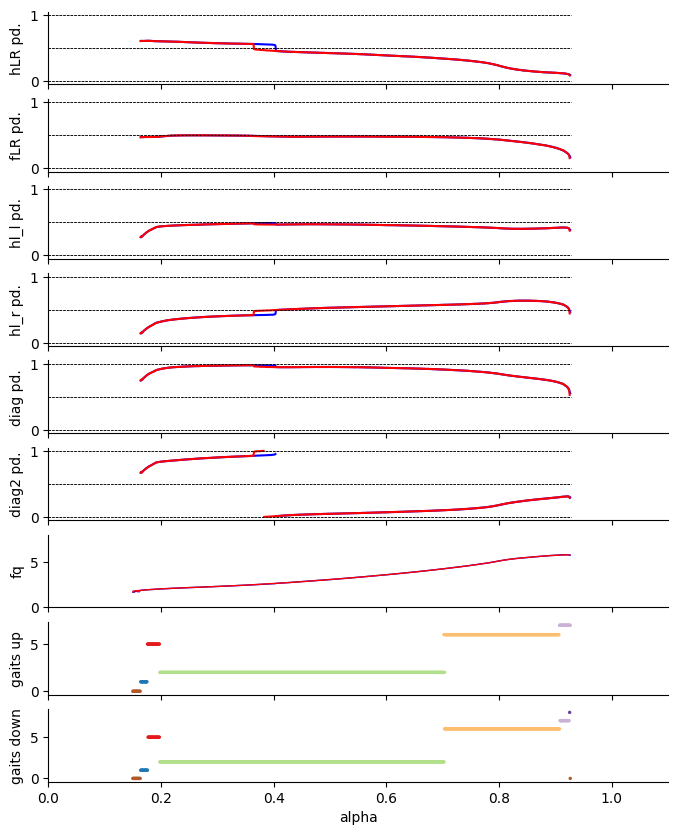

In [13]:
run_1d_bifurcation('./models/config_hemi_final_only_affected_LPNs.yaml',a_range=[0.15,0.926])

## Bifurcation diagram: only drive to ipsilesional hind RG reduced to 90% of preinjury (Figure 9A4)
All other parameters were left at their pre-injury values


updating variables
group update - name: ipsilesional_hind_RGF_drive , group: RGF_drive_vars , postfix: ['_h_R'] , factor: 0.9
variable name         from     -> to      
drive_to_RGF_h_R     0.0000100 -> 0.0000090




max iterations reached - max std phases: 0.038 > limit 0.005 - variable: alpha    0.120
max iterations reached - max std phases: 0.193 > limit 0.005 - variable: alpha    0.121
max iterations reached - max std phases: 0.169 > limit 0.005 - variable: alpha    0.122
max iterations reached - max std phases: 0.013 > limit 0.005 - variable: alpha    0.123
max iterations reached - max std phases: 0.009 > limit 0.005 - variable: alpha    0.124
Iter 10 of 841*2; It/sec 0.282
Iter 20 of 841*2; It/sec 2.488
Iter 30 of 841*2; It/sec 2.292
Iter 40 of 841*2; It/sec 2.150
Iter 50 of 841*2; It/sec 1.988
Iter 60 of 841*2; It/sec 2.095
Iter 70 of 841*2; It/sec 2.021
Iter 80 of 841*2; It/sec 2.374
Iter 90 of 841*2; It/sec 2.487
Iter 100 of 841*2; It/sec 2.505
Iter 110 of 841*2; It/sec 2.402

/var/folders/fz/27jjxdfx3jz5zh_vzsrj6dcm0000gp/T/ipykernel_73571/2984254066.py:76: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(pdu) < 2*np.pi+0.05:


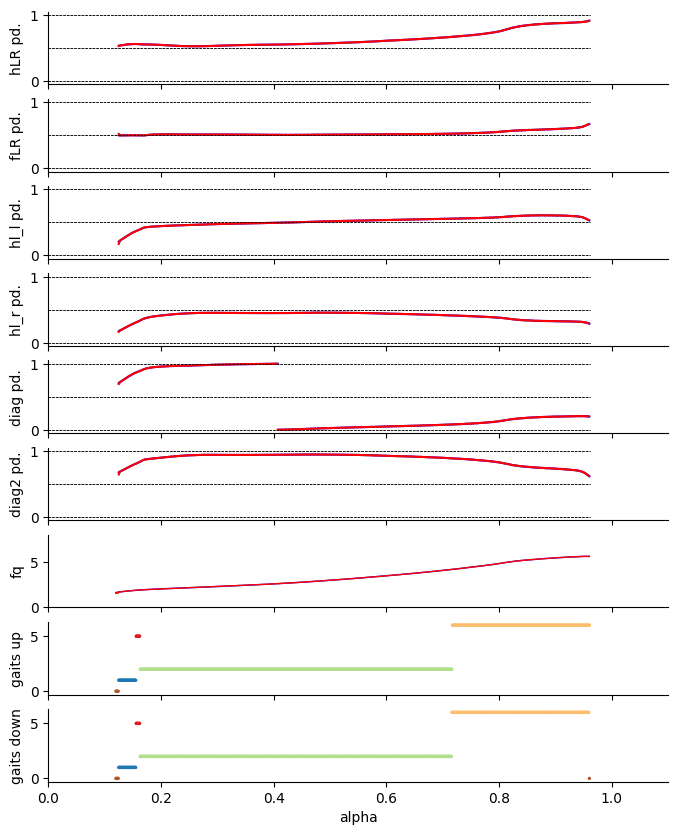

In [14]:
run_1d_bifurcation('./models/config_hemi_final_only_ipsi_hind_RG.yaml',a_range=[0.12,0.96])